In [ ]:
# ================================================
# CS667 – Project #2  |  Practical Data Science
# Regression Modeling on Retail Sales Dataset
# ================================================

import warnings
warnings.filterwarnings("ignore")

import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import metrics

# optional: XGBoost
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

sns.set_theme(style="whitegrid", palette="deep")

DATA_PATH = "retail_data_synthetic_50k.xlsx"     # <--- replace with your file name
OUT_DIR   = "outputs_cs667"
FIG_DIR   = os.path.join(OUT_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)


In [ ]:
df = pd.read_excel(DATA_PATH)
df.columns = [c.strip().replace("\n"," ").replace("\r"," ") for c in df.columns]

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

# Convert currency or strings to numeric
for col in df.columns:
    if df[col].dtype == 'object':
        if df[col].str.contains(r'\$|,').any():
            df[col] = df[col].replace('[\$,]', '', regex=True).astype(float)

# Detect target
for possible in ["Total Amount","Total_Amount","Revenue","Sales","Amount"]:
    if possible in df.columns:
        target_col = possible
        break
else:
    target_col = "Total_Amount"
    df[target_col] = df["Quantity"] * df["Price per Unit"]

print("Target variable:", target_col)


Dataset shape: (50000, 13)
Columns: ['Transaction_ID', 'Customer_ID', 'Gender', 'Age', 'Category', 'Quantity', 'Unit_Price', 'Discount', 'Date', 'Store_Region', 'Online_Or_Offline', 'Payment_Method', 'Total_Amount']
Target variable: Total_Amount


In [ ]:
# Date-based features
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["DayOfWeek"] = df["Date"].dt.dayofweek
    df["IsWeekend"] = df["DayOfWeek"].isin([5,6]).astype(int)

# Derived Season
def season(m):
    if pd.isna(m): return np.nan
    if m in [12,1,2]: return "Winter"
    if m in [3,4,5]: return "Spring"
    if m in [6,7,8]: return "Summer"
    return "Fall"
if "Month" in df.columns:
    df["Season"] = df["Month"].apply(season)

# Drop obvious IDs
drop_cols = [c for c in df.columns if "ID" in c or "Id" in c]
feature_cols = [c for c in df.columns if c not in drop_cols + [target_col]]

numeric_cols = df[feature_cols].select_dtypes(include=np.number).columns.tolist()
categorical_cols = [c for c in feature_cols if c not in numeric_cols]

print("Numeric:", numeric_cols)
print("Categorical:", categorical_cols)


Numeric: ['Age', 'Quantity', 'Unit_Price', 'Discount', 'Year', 'Month', 'DayOfWeek', 'IsWeekend']
Categorical: ['Gender', 'Category', 'Date', 'Store_Region', 'Online_Or_Offline', 'Payment_Method', 'Season']


In [ ]:
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocess = ColumnTransformer([
    ("num", num_pipe, numeric_cols),
    ("cat", cat_pipe, categorical_cols)
])

X = df[feature_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")


Train size: (40000, 15), Test size: (10000, 15)


In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}
if HAS_XGB:
    models["XGBoost"] = XGBRegressor(n_estimators=300, learning_rate=0.05,
                                     max_depth=6, subsample=0.8,
                                     colsample_bytree=0.8, random_state=42)

results = []
for name, model in models.items():
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    r2 = metrics.r2_score(y_test, preds)
    mae = metrics.mean_absolute_error(y_test, preds)
    rmse = math.sqrt(metrics.mean_squared_error(y_test, preds))
    results.append((name, r2, mae, rmse, pipe, preds))
    print(f"{name:18s}  R²={r2:.4f}  MAE={mae:.2f}  RMSE={rmse:.2f}")

perf = pd.DataFrame(results, columns=["Model","R2","MAE","RMSE","Pipe","Preds"]).sort_values("R2", ascending=False)
display(perf[["Model","R2","MAE","RMSE"]])


Linear Regression   R²=0.8551  MAE=238.81  RMSE=321.29
Decision Tree       R²=0.9992  MAE=15.52  RMSE=24.17
Random Forest       R²=0.9999  MAE=6.06  RMSE=9.92
Gradient Boosting   R²=0.9984  MAE=25.97  RMSE=33.79
XGBoost             R²=0.9998  MAE=8.42  RMSE=11.72


Model        R2         MAE        RMSE
2      Random Forest  0.999862    6.055542    9.915487
4            XGBoost  0.999807    8.419778   11.723436
1      Decision Tree  0.999180   15.517290   24.172823
3  Gradient Boosting  0.998397   25.969342   33.792804
0  Linear Regression  0.855083  238.810337  321.294386


Best model: Random Forest


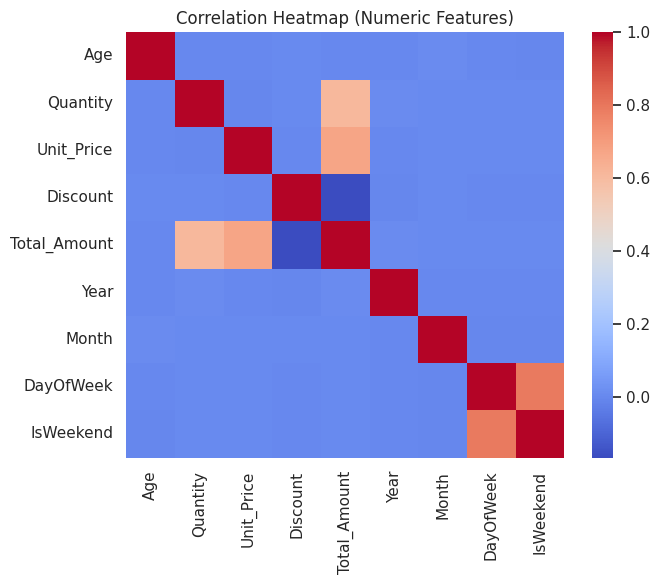

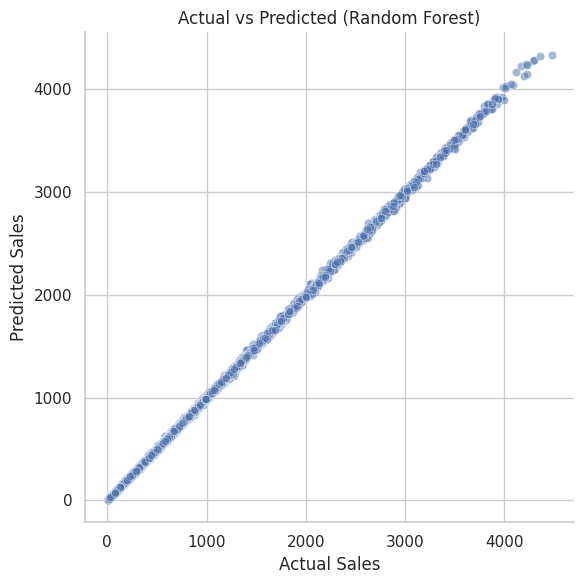

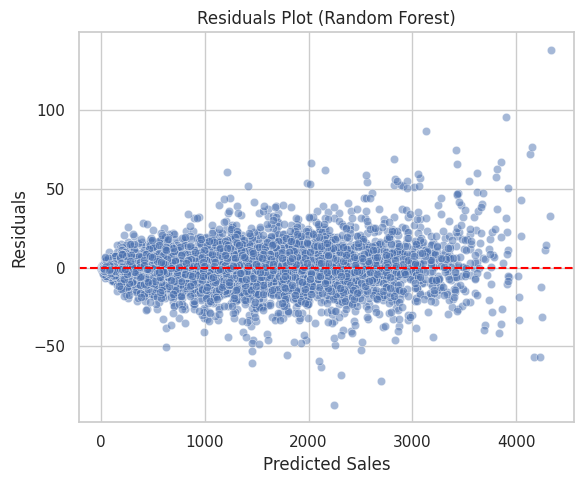

In [ ]:
best = perf.iloc[0]
best_name, best_pipe, best_preds = best["Model"], best["Pipe"], best["Preds"]
print(f"\nBest model: {best_name}")

# ---- Correlation Heatmap ----
plt.figure(figsize=(7,6))
sns.heatmap(df.select_dtypes(np.number).corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap (Numeric Features)")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR,"correlation_heatmap.png"))
plt.show()

# ---- Actual vs Predicted ----
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=best_preds, alpha=0.5)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title(f"Actual vs Predicted ({best_name})")
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR,"actual_vs_predicted.png"))
plt.show()

# ---- Residuals ----
residuals = y_test - best_preds
plt.figure(figsize=(6,5))
sns.scatterplot(x=best_preds, y=residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Sales")
plt.ylabel("Residuals")
plt.title(f"Residuals Plot ({best_name})")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR,"residuals.png"))
plt.show()


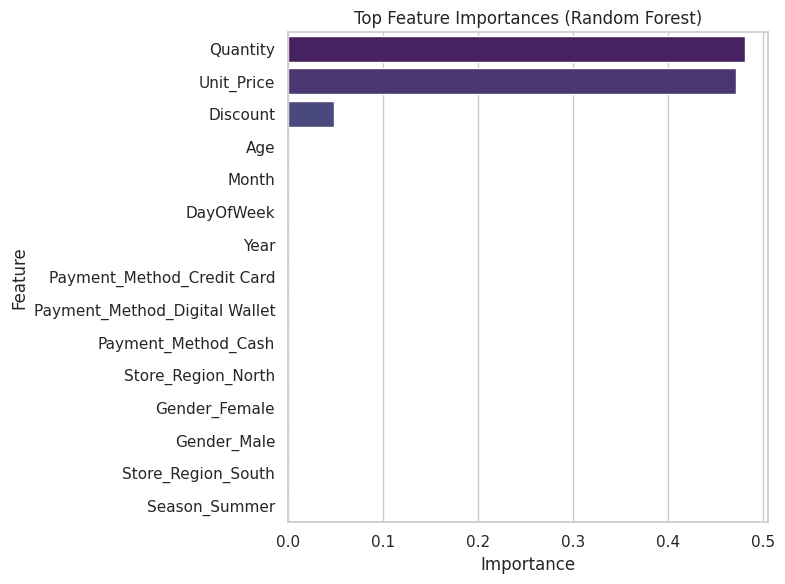

In [ ]:
model = best_pipe.named_steps["model"]
if hasattr(model, "feature_importances_"):
    ohe = best_pipe.named_steps["prep"].named_transformers_["cat"].named_steps["encoder"]
    cat_names = list(ohe.get_feature_names_out(categorical_cols)) if categorical_cols else []
    all_features = numeric_cols + cat_names
    fi = pd.DataFrame({"Feature": all_features, "Importance": model.feature_importances_})
    top = fi.sort_values("Importance", ascending=False).head(15)

    plt.figure(figsize=(8,6))
    sns.barplot(y="Feature", x="Importance", data=top, palette="viridis")
    plt.title(f"Top Feature Importances ({best_name})")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR,"feature_importances.png"))
    plt.show()
else:
    print("Feature importances not available for this model.")


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ---- Correlation Heatmap (Plotly) ----
corr = df.select_dtypes(np.number).corr()
fig_corr = px.imshow(
    corr,
    text_auto=True,
    color_continuous_scale="RdBu_r",
    title="Correlation Heatmap (Numeric Features)",
    aspect="auto"
)
fig_corr.update_layout(width=700, height=600)
fig_corr.show()
fig_corr.write_html(os.path.join(FIG_DIR, "correlation_heatmap.html"))

# ---- Actual vs Predicted (interactive scatter) ----
fig_avp = px.scatter(
    x=y_test, y=best_preds,
    labels={"x": "Actual Sales", "y": "Predicted Sales"},
    title=f"Actual vs Predicted – {best_name}",
    color_discrete_sequence=["#1f77b4"]
)
fig_avp.add_trace(go.Scatter(x=[y_test.min(), y_test.max()],
                             y=[y_test.min(), y_test.max()],
                             mode="lines",
                             name="Perfect Fit",
                             line=dict(color="red", dash="dash")))
fig_avp.update_layout(width=600, height=600)
fig_avp.show()
fig_avp.write_html(os.path.join(FIG_DIR, "actual_vs_predicted.html"))

# ---- Residuals (interactive) ----
residuals = y_test - best_preds
fig_resid = px.scatter(
    x=best_preds, y=residuals,
    labels={"x": "Predicted", "y": "Residuals"},
    title=f"Residuals Plot – {best_name}",
    color_discrete_sequence=["#636EFA"]
)
fig_resid.add_hline(y=0, line_dash="dash", line_color="red")
fig_resid.update_layout(width=600, height=500)
fig_resid.show()
fig_resid.write_html(os.path.join(FIG_DIR, "residuals.html"))


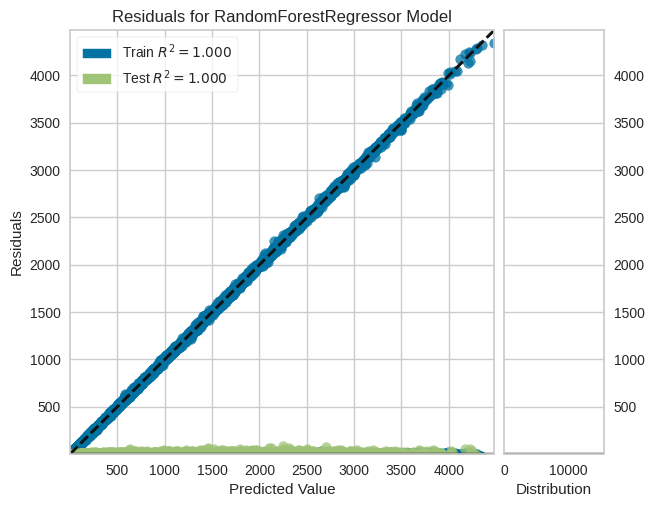

In [ ]:
# --- Feature importances using Plotly ---
model = best_pipe.named_steps["model"]
importances = None

# reconstruct feature names
try:
    ohe = best_pipe.named_steps["prep"].named_transformers_["cat"].named_steps["encoder"]
    cat_features = list(ohe.get_feature_names_out(categorical_cols)) if categorical_cols else []
except Exception:
    cat_features = []
all_features = numeric_cols + cat_features

if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
elif hasattr(model, "coef_"):
    importances = np.abs(model.coef_)

if importances is not None and len(all_features) == len(importances):
    fi = pd.DataFrame({"Feature": all_features, "Importance": importances})
    fi = fi.sort_values("Importance", ascending=False).head(15)

    fig_fi = px.bar(
        fi,
        x="Importance", y="Feature",
        orientation="h",
        title=f"Top 15 Feature Importances – {best_name}",
        color="Importance", color_continuous_scale="Viridis"
    )
    fig_fi.update_layout(width=700, height=600, yaxis=dict(autorange="reversed"))
    fig_fi.show()
    fig_fi.write_html(os.path.join(FIG_DIR, "feature_importances.html"))
else:
    print("Feature importances not available for this model.")

# --- Optional Yellowbrick model diagnostics ---
from yellowbrick.regressor import ResidualsPlot, PredictionError

if hasattr(model, "predict"):
    visualizer = PredictionError(model)
    visualizer.fit(best_pipe.named_steps["prep"].transform(X_train), y_train)
    visualizer.score(best_pipe.named_steps["prep"].transform(X_test), y_test)
    visualizer.show(outpath=os.path.join(FIG_DIR, "prediction_error_yb.png"))

    res_viz = ResidualsPlot(model)
    res_viz.fit(best_pipe.named_steps["prep"].transform(X_train), y_train)
    res_viz.score(best_pipe.named_steps["prep"].transform(X_test), y_test)
    res_viz.show(outpath=os.path.join(FIG_DIR, "residuals_yb.png"))


In [ ]:
import plotly.express as px

# --- Total Sales by Product Category ---
if "Product Category" in df.columns:
    fig_cat = px.bar(
        df.groupby("Product Category")[target_col].sum().reset_index(),
        x="Product Category", y=target_col,
        color="Product Category", text_auto=True,
        title="Total Sales by Product Category",
        color_discrete_sequence=px.colors.qualitative.Safe
    )
    fig_cat.update_layout(yaxis_title="Total Sales ($)", xaxis_title="Product Category")
    fig_cat.show()

# --- Monthly Sales Trend (Seasonality) ---
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    trend = df.groupby(df["Date"].dt.to_period("M"))[target_col].sum().reset_index()
    trend["Date"] = trend["Date"].astype(str)
    fig_trend = px.line(
        trend, x="Date", y=target_col,
        title="Monthly Sales Trend Over Time",
        markers=True, color_discrete_sequence=["#1f77b4"]
    )
    fig_trend.update_layout(xaxis_title="Month", yaxis_title="Total Sales ($)")
    fig_trend.show()

# --- Gender-Based Sales Distribution (if available) ---
if "Gender" in df.columns:
    fig_gender = px.pie(
        df, names="Gender", values=target_col,
        color="Gender", title="Sales Distribution by Gender",
        color_discrete_sequence=px.colors.sequential.RdBu
    )
    fig_gender.show()


In [ ]:
!pip install catboost shap xgboost --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [ ]:
import os, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import metrics

from catboost import CatBoostRegressor, Pool

try:
    from xgboost import XGBRegressor  # optional
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# ---- set your file name here ----
DATA_PATH = "retail_data_synthetic_50k.xlsx"     # e.g., "retail_sales.xlsx"

OUT_DIR = "outputs_cs667"
FIG_DIR = os.path.join(OUT_DIR, "figures")
os.makedirs(FIG_DIR, exist_ok=True)


In [ ]:
assert os.path.exists(DATA_PATH), f"File not found: {DATA_PATH}"
df = pd.read_excel(DATA_PATH)
df.columns = [c.strip().replace("\n"," ").replace("\r"," ") for c in df.columns]

print("Shape:", df.shape)
print("Columns:", list(df.columns))

# Standardize common names (map a few retail variants)
rename_map = {
    "Transaction ID":"Transaction_ID", "Customer ID":"Customer_ID",
    "Product Category":"Category", "Price per Unit":"Unit_Price",
    "Price Per Unit":"Unit_Price", "Price":"Unit_Price",
    "Total Amount":"Total_Amount", "Total":"Total_Amount", "Sales":"Total_Amount", "Revenue":"Total_Amount",
    "Store Region":"Store_Region", "Online/Offline":"Online_Or_Offline"
}
df = df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns})

# Ensure numeric conversions
for col in df.columns:
    if df[col].dtype == "object":
        # strip $ and commas if any numeric-like strings
        if df[col].astype(str).str.contains(r"[\$,]", regex=True).any():
            df[col] = df[col].astype(str).str.replace(r"[,\$]", "", regex=True)

# Identify/compute target
target_col = "Total_Amount" if "Total_Amount" in df.columns else None
if target_col is None:
    qty_col = next((c for c in df.columns if c.lower() in ["quantity","qty"]), None)
    price_col = next((c for c in df.columns if c.lower() in ["unit_price","price per unit","price"]), None)
    if qty_col and price_col:
        df["Total_Amount"] = pd.to_numeric(df[qty_col], errors="coerce") * pd.to_numeric(df[price_col], errors="coerce")
        target_col = "Total_Amount"
    else:
        # fallback: last numeric column
        num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        assert len(num_cols) > 0, "No numeric target found; please add/compute Total_Amount."
        target_col = num_cols[-1]

# Force numerics for key numeric fields
for col in ["Age","Quantity","Unit_Price","Discount",target_col]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Drop rows with missing target
before = len(df)
df = df.dropna(subset=[target_col]).reset_index(drop=True)
print(f"Dropped {before - len(df)} rows with missing target → final rows: {len(df)}")

print("Preview:")
df.head()


Shape: (50000, 13)
Columns: ['Transaction_ID', 'Customer_ID', 'Gender', 'Age', 'Category', 'Quantity', 'Unit_Price', 'Discount', 'Date', 'Store_Region', 'Online_Or_Offline', 'Payment_Method', 'Total_Amount']
Dropped 0 rows with missing target → final rows: 50000
Preview:


Transaction_ID Customer_ID      Gender  Age     Category  Quantity  \
0      TXN-00000   CUST-1127      Female   60    Furniture         9   
1      TXN-00001   CUST-1460        Male   30       Beauty         4   
2      TXN-00002   CUST-0861        Male   52     Clothing         1   
3      TXN-00003   CUST-1295  Non-binary   38  Electronics         7   
4      TXN-00004   CUST-1131        Male   47      Grocery         2   

   Unit_Price  Discount       Date Store_Region Online_Or_Offline  \
0      202.12      0.26 2023-02-12        North            Online   
1       75.03      0.05 2021-12-04         West            Online   
2      374.66      0.15 2020-10-21        South            Online   
3       71.98      0.30 2020-04-26         East            Online   
4      169.25      0.02 2022-06-03         West            Online   

   Payment_Method  Total_Amount  
0  Digital Wallet       1346.12  
1  Digital Wallet        285.11  
2            Cash        318.46  
3     Credit Card        352.70  
4            Cash        331.73

In [ ]:
# Date and time features (if present)
date_candidates = [c for c in df.columns if "date" in c.lower()]
if date_candidates:
    dcol = date_candidates[0]
    df[dcol] = pd.to_datetime(df[dcol], errors="coerce")
    df["Year"]       = df[dcol].dt.year
    df["Month"]      = df[dcol].dt.month
    df["DayOfWeek"]  = df[dcol].dt.dayofweek
    df["IsWeekend"]  = df["DayOfWeek"].isin([5,6]).astype(int)
else:
    dcol = None

def season(m):
    if pd.isna(m): return np.nan
    m = int(m)
    if m in [12,1,2]: return "Winter"
    if m in [3,4,5]: return "Spring"
    if m in [6,7,8]: return "Summer"
    return "Fall"

if "Month" in df.columns:
    df["Season"] = df["Month"].apply(season)

# Define features (exclude IDs and the target)
id_like = {"Transaction_ID","Customer_ID"}
feature_cols = [c for c in df.columns if c not in id_like | {target_col}]

# Candidate numeric/categorical sets
numeric_cols = [c for c in ["Age","Quantity","Unit_Price","Discount","Year","Month","DayOfWeek","IsWeekend"] if c in df.columns]
categorical_cols = [c for c in ["Gender","Category","Store_Region","Online_Or_Offline","Payment_Method","Season"] if c in df.columns]

# If some remain unlabeled, infer:
more_num = df[feature_cols].select_dtypes(include=[np.number]).columns.difference(numeric_cols).tolist()
more_cat = [c for c in df[feature_cols].select_dtypes(exclude=[np.number]).columns if c not in categorical_cols]
numeric_cols += more_num
categorical_cols += more_cat

X = df[feature_cols].copy()
y = df[target_col].copy()

print("Numeric:", numeric_cols[:12], "..." if len(numeric_cols)>12 else "")
print("Categorical:", categorical_cols[:12], "..." if len(categorical_cols)>12 else "")


Numeric: ['Age', 'Quantity', 'Unit_Price', 'Discount', 'Year', 'Month', 'DayOfWeek', 'IsWeekend'] 
Categorical: ['Gender', 'Category', 'Store_Region', 'Online_Or_Offline', 'Payment_Method', 'Season', 'Date'] 


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (40000, 15) Test: (10000, 15)


In [ ]:
# Preprocess: scale numeric + one-hot categorical for sklearn models
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])
preprocess = ColumnTransformer([
    ("num", num_pipe, numeric_cols),
    ("cat", cat_pipe, categorical_cols)
])

models = {
    "LinearRegression": LinearRegression(),
    "DecisionTree":     DecisionTreeRegressor(random_state=42),
    "RandomForest":     RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

def train_eval(name, model):
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    r2   = metrics.r2_score(y_test, preds)
    mae  = metrics.mean_absolute_error(y_test, preds)
    rmse = math.sqrt(metrics.mean_squared_error(y_test, preds))
    return name, pipe, preds, r2, mae, rmse

sk_results = [train_eval(n, m) for n,m in models.items()]
perf_sklearn = pd.DataFrame([{
    "Model": n, "R2": r2, "MAE": mae, "RMSE": rmse
} for (n, pipe, preds, r2, mae, rmse) in sk_results]).sort_values(["R2","RMSE"], ascending=[False, True])
perf_sklearn


Model        R2         MAE        RMSE
2      RandomForest  0.999863    6.030484    9.876366
1      DecisionTree  0.999179   15.621586   24.176961
3  GradientBoosting  0.998397   25.969342   33.792804
0  LinearRegression  0.855083  238.810349  321.294389

In [23]:
# --- FIX CatBoost Date Error ---
# Convert any datetime columns to string format before building Pool
for c in X_train.select_dtypes(include=['datetime64[ns]']).columns:
    X_train[c] = X_train[c].astype(str)
    X_test[c]  = X_test[c].astype(str)

# Identify categorical feature indexes
cat_idx = [X_train.columns.get_loc(c) for c in categorical_cols if c in X_train.columns]

# CatBoost: native categorical handling
train_pool = Pool(X_train, y_train, cat_features=cat_idx)
test_pool  = Pool(X_test,  y_test,  cat_features=cat_idx)

cat_model = CatBoostRegressor(
    depth=8,
    learning_rate=0.05,
    n_estimators=600,
    loss_function="RMSE",
    random_state=42,
    verbose=False
)
cat_model.fit(train_pool, eval_set=test_pool, verbose=False)

cat_preds = cat_model.predict(test_pool)
cat_perf = {
    "Model": "CatBoost",
    "R2": metrics.r2_score(y_test, cat_preds),
    "MAE": metrics.mean_absolute_error(y_test, cat_preds),
    "RMSE": math.sqrt(metrics.mean_squared_error(y_test, cat_preds))
}
perf_cat = pd.DataFrame([cat_perf])

# Optional XGBoost (reuse sklearn preprocess to OHE + scale)
if HAS_XGB:
    xgb = XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=42,
        tree_method="hist"
    )
    xgb_pipe = Pipeline([("prep", preprocess), ("model", xgb)])
    xgb_pipe.fit(X_train, y_train)
    xgb_preds = xgb_pipe.predict(X_test)
    perf_xgb = pd.DataFrame([{
        "Model": "XGBoost",
        "R2": metrics.r2_score(y_test, xgb_preds),
        "MAE": metrics.mean_absolute_error(y_test, xgb_preds),
        "RMSE": math.sqrt(metrics.mean_squared_error(y_test, xgb_preds))
    }])
else:
    perf_xgb = pd.DataFrame(columns=["Model","R2","MAE","RMSE"])

# Combine results
perf_all = pd.concat([perf_sklearn, perf_cat, perf_xgb], ignore_index=True)\
             .sort_values(["R2","RMSE"], ascending=[False, True])
perf_all


Model        R2         MAE        RMSE
4          CatBoost  0.999938    4.933791    6.667271
0      RandomForest  0.999863    6.030484    9.876366
5           XGBoost  0.999635   11.030463   16.120397
1      DecisionTree  0.999179   15.621586   24.176961
2  GradientBoosting  0.998397   25.969342   33.792804
3  LinearRegression  0.855083  238.810349  321.294389

from matplotlib import pyplot as plt
perf_all['R2'].plot(kind='hist', bins=20, title='R2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
perf_all['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
perf_all['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
perf_all.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
perf_all.plot(kind='scatter', x='R2', y='MAE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
perf_all.plot(kind='scatter', x='MAE', y='RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['MAE']
  ys = series['R2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = perf_all.sort_values('MAE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MAE')
_ = plt.ylabel('R2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['MAE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'MAE'}, axis=1)
              .sort_values('MAE', ascending=True))
  xs = counted['MAE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = perf_all.sort_values('MAE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MAE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['RMSE']
  ys = series['R2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = perf_all.sort_values('RMSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE')
_ = plt.ylabel('R2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['RMSE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'RMSE'}, axis=1)
              .sort_values('RMSE', ascending=True))
  xs = counted['RMSE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = perf_all.sort_values('RMSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
perf_all['R2'].plot(kind='line', figsize=(8, 4), title='R2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
perf_all['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
perf_all['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(perf_all['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(perf_all, x='R2', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(perf_all['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(perf_all, x='MAE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(perf_all['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(perf_all, x='RMSE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['R2'].plot(kind='hist', bins=20, title='R2')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['MAE'].plot(kind='hist', bins=20, title='MAE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['RMSE'].plot(kind='hist', bins=20, title='RMSE')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='index', y='R2', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='R2', y='MAE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='MAE', y='RMSE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['MAE']
  ys = series['index']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('MAE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MAE')
_ = plt.ylabel('index')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['MAE']
  ys = series['R2']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('MAE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MAE')
_ = plt.ylabel('R2')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['MAE']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'MAE'}, axis=1)
              .sort_values('MAE', ascending=True))
  xs = counted['MAE']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('MAE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('MAE')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['RMSE']
  ys = series['index']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('RMSE', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE')
_ = plt.ylabel('index')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['R2'].plot(kind='line', figsize=(8, 4), title='R2')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['MAE'].plot(kind='line', figsize=(8, 4), title='MAE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['RMSE'].plot(kind='line', figsize=(8, 4), title='RMSE')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='index', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='R2', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='MAE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='RMSE', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [24]:
best_row = perf_all.iloc[0]
best_name = best_row["Model"]

# Get predictions for the best model
if best_name == "CatBoost":
    best_preds = cat_preds
elif best_name == "XGBoost" and HAS_XGB:
    best_preds = xgb_preds
else:
    d = {n: (pipe, preds) for (n, pipe, preds, _, _, _) in sk_results}
    best_pipe, best_preds = d[best_name]

print(f"Best model: {best_name} | R2={best_row['R2']:.4f} | MAE={best_row['MAE']:.2f} | RMSE={best_row['RMSE']:.2f}")

os.makedirs(OUT_DIR, exist_ok=True)
perf_all.to_csv(os.path.join(OUT_DIR,"performance_summary.csv"), index=False)


Best model: CatBoost | R2=0.9999 | MAE=4.93 | RMSE=6.67


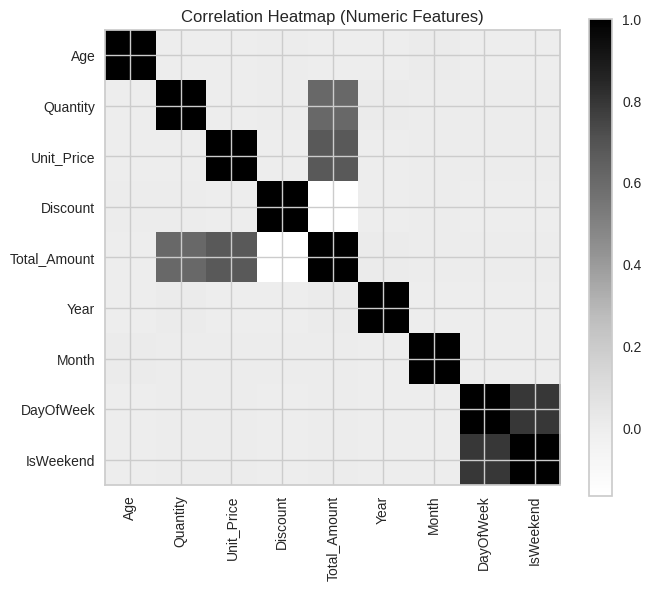

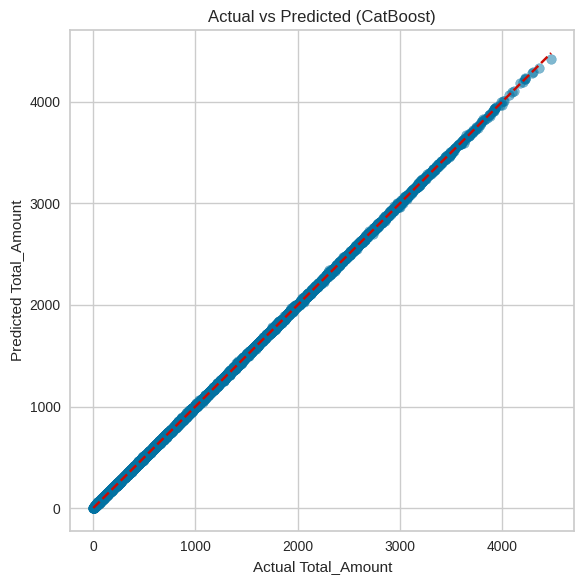

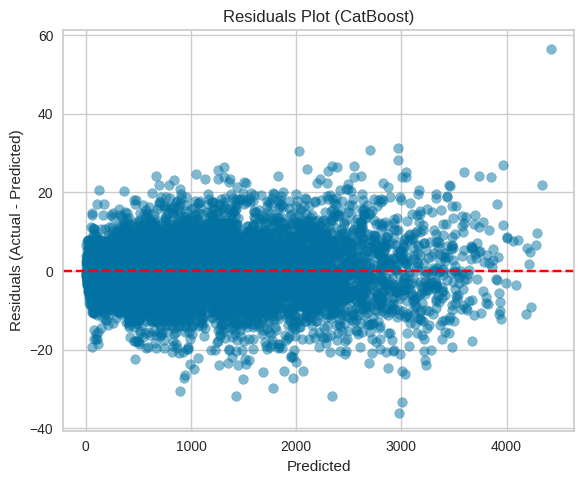

In [25]:
# Correlation heatmap (numeric only)
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols_all) >= 2:
    corr = df[num_cols_all].corr(numeric_only=True)
    plt.figure(figsize=(7,6))
    plt.imshow(corr.values, interpolation="nearest")
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.index)), corr.index)
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR,"correlation_heatmap.png"), dpi=160)
    plt.show()

# Actual vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, best_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel(f"Actual {target_col}")
plt.ylabel(f"Predicted {target_col}")
plt.title(f"Actual vs Predicted ({best_name})")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR,"actual_vs_predicted.png"), dpi=160)
plt.show()

# Residuals
residuals = y_test - best_preds
plt.figure(figsize=(6,5))
plt.scatter(best_preds, residuals, alpha=0.5)
plt.axhline(0, linestyle="--", color="red")
plt.xlabel("Predicted")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title(f"Residuals Plot ({best_name})")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR,"residuals.png"), dpi=160)
plt.show()


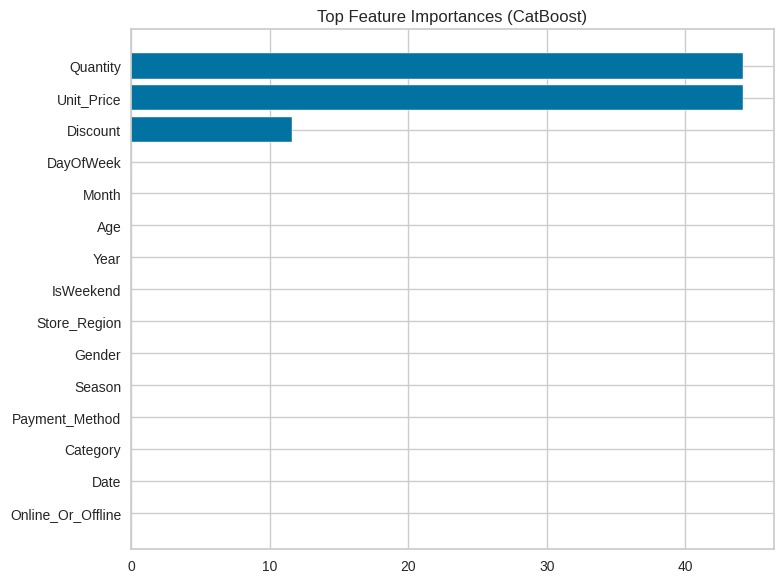

In [26]:
if best_name == "CatBoost":
    fi_vals = cat_model.get_feature_importance(train_pool, type="FeatureImportance")
    fi = pd.DataFrame({"Feature": X_train.columns, "Importance": fi_vals})\
            .sort_values("Importance", ascending=False)

    plt.figure(figsize=(8,6))
    top = fi.head(15).iloc[::-1]
    plt.barh(top["Feature"], top["Importance"])
    plt.title("Top Feature Importances (CatBoost)")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR,"feature_importances.png"), dpi=160)
    plt.show()
else:
    # Rebuild feature names for sklearn preprocess
    try:
        ohe = preprocess.named_transformers_["cat"].named_steps["encoder"]
        cat_names = list(ohe.get_feature_names_out(categorical_cols))
    except Exception:
        cat_names = []
    all_names = numeric_cols + cat_names

    if best_name == "XGBoost" and HAS_XGB:
        model_obj = xgb
    else:
        # pull model from pipeline
        model_obj = dict((n, pipe) for (n, pipe, _, _, _, _) in sk_results)[best_name].named_steps["model"]

    if hasattr(model_obj, "feature_importances_") and len(all_names)==len(model_obj.feature_importances_):
        imp = pd.DataFrame({"Feature": all_names, "Importance": model_obj.feature_importances_})\
                 .sort_values("Importance", ascending=False)
        plt.figure(figsize=(8,6))
        top = imp.head(15).iloc[::-1]
        plt.barh(top["Feature"], top["Importance"])
        plt.title(f"Top Feature Importances ({best_name})")
        plt.tight_layout()
        plt.savefig(os.path.join(FIG_DIR,"feature_importances.png"), dpi=160)
        plt.show()
    else:
        print("Feature importances not available for this model.")
